In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import  classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
import warnings
warnings.filterwarnings("ignore")


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_excel('new_final_df.xlsx')
df.head()

,Stkcd,Trddt,Opnprc,Hiprc,Loprc,Clsprc,Dnshrtrd,Dnvaltrd,Dsmvosd,Dsmvtll,...,PB,PS,CirculatedMarketValue,Turnover,Financeamount,SellShareValue,billboard_weight,large_alpha,fs_alpha,is_one
0,1,2024-02-21,9.78,10.80,9.77,10.80,505528460,5.295259e+09,2.095799e+08,2.095839e+08,...,0.443725,1.416500,2.095799e+11,0.02605,937121027.0,24979019.0,2.280165,15.24,0.004352,0
1,1,2024-02-22,10.65,10.91,10.62,10.90,492232512,5.307736e+09,2.115205e+08,2.115245e+08,...,0.447834,1.429616,2.115205e+11,0.02537,736178650.0,8749315.0,NaN,-1.37,0.003439,0
2,2,2024-04-29,6.77,7.56,6.76,7.56,494465959,3.593552e+09,7.346004e+07,7.351493e+07,...,0.223849,0.193662,9.014127e+10,0.05089,573983970.0,3613422.0,2.440592,9.24,0.006328,0
3,2,2024-04-30,7.70,7.79,7.35,7.41,630797485,4.741698e+09,7.200249e+07,7.205630e+07,...,0.219407,0.189820,8.835276e+10,0.06492,531146054.0,5728698.0,NaN,-24.58,0.005947,0
4,2,2024-05-17,8.33,9.00,8.00,9.00,924718412,7.817273e+09,8.745242e+07,8.751777e+07,...,0.266487,0.230551,1.073110e+11,0.09517,958162344.0,11788656.0,-0.379270,3.33,0.008819,0


In [3]:
def discretize(value):
    if -0.02 <= value < 0.02:
        return 0
    elif 0.02 <= value < 0.06:
        return 1
    elif 0.06 <= value:
        return 2
    elif -0.06 <= value < -0.02:
        return -1
    elif value < -0.06:
        return -2

df['discrete'] = None
for stock_id, group in df.groupby('Stkcd'):
    for i in range(len(group) - 1):  # 只遍历到倒数第二天
        if group.iloc[i]['LimitStatus'] == 1:
            # 对下一天的ChangeRatio进行离散化
            next_day_index = i + 1
            if next_day_index < len(group):
                df.loc[group.index[next_day_index], 'discrete'] = discretize(group.iloc[next_day_index]['ChangeRatio'])

print(df['discrete'])

0        None
1           0
2        None
3           0
4        None
         ... 
17348       0
17349    None
17350       2
17351    None
17352      -1
Name: discrete, Length: 17353, dtype: object


In [4]:
df['PB'] = df.groupby('Stkcd')['PB'].transform(lambda x: x.fillna(x.mean()))
df['PS'] = df.groupby('Stkcd')['PS'].transform(lambda x: x.fillna(x.mean()))
df['Turnover'] = df['Turnover'].fillna(df['ITurnover'])

In [5]:
columns_to_fill = ['PB', 'PS', 'CirculatedMarketValue', 'billboard_weight', 'large_alpha', 'fs_alpha']
df[columns_to_fill] = df[columns_to_fill].fillna(0)


In [6]:
df.dropna(subset=['discrete'], inplace=True)

In [7]:
feature = ['ConsecutiveLimitUp','IndcdZX','ITurnover','IChangeRatio','PB','PS','CirculatedMarketValue','Turnover','billboard_weight','large_alpha','fs_alpha','discrete','is_one']
df = df[feature]
df

,ConsecutiveLimitUp,IndcdZX,ITurnover,IChangeRatio,PB,PS,CirculatedMarketValue,Turnover,billboard_weight,large_alpha,fs_alpha,discrete,is_one
1,1,J66,0.00408,0.000957,0.447834,1.429616,2.115205e+11,0.02537,0.000000,-1.37,0.003439,0,0
3,1,K70,0.02337,-0.018039,0.219407,0.189820,8.835276e+10,0.06492,0.000000,-24.58,0.005947,0,0
5,1,K70,0.04191,-0.014990,0.271816,0.235162,1.094573e+11,0.09066,0.000000,-5.24,0.010254,1,0
7,1,I65,0.01748,-0.003763,6.199930,13.129612,2.085016e+09,0.20578,0.000000,-34.78,0.000000,0,0
9,1,I65,0.03230,0.008655,6.594232,13.964627,2.217619e+09,0.29617,0.000000,-39.97,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17344,1,C39,0.02602,-0.017105,3.200955,3.770827,1.058422e+09,0.33236,-0.531862,-2.61,0.000000,-2,0
17346,1,C39,0.01963,-0.018675,3.527198,4.155152,1.166297e+09,0.42522,-1.120934,-13.57,0.000000,0,0
17348,1,C39,0.01959,0.000875,3.046566,3.588952,1.007372e+09,0.39606,-4.156986,-13.38,0.000000,0,0
17350,1,C26,0.01737,0.026326,1.587824,1.667577,1.192896e+10,0.02904,0.000000,-18.90,0.000404,2,0


In [8]:

# 假设 df 是您的数据框
# 定义需要标准化的列
columns_to_standardize = ['ITurnover', 'IChangeRatio', 'PB', 'PS', 
                            'Turnover', ]

# 创建标准化器
scaler = StandardScaler()

# 进行标准化，注意这里使用了 loc 以确保只修改需要标准化的列
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# 打印标准化后的数据框（可选）
print(df[columns_to_standardize].head())

   ITurnover  IChangeRatio        PB        PS  Turnover
1  -1.082747      0.010881 -0.601801 -0.315453 -0.877947
3   0.221032     -1.110341 -0.641098 -0.425879 -0.535444
5   1.474120     -0.930376 -0.632082 -0.421840 -0.312536
7  -0.177063     -0.267713  0.387752  0.726638  0.684401
9   0.824596      0.465248  0.455585  0.801011  1.467177


In [9]:
missing_counts = df.isnull().sum()
print(missing_counts)

ConsecutiveLimitUp       0
IndcdZX                  0
ITurnover                0
IChangeRatio             0
PB                       0
PS                       0
CirculatedMarketValue    0
Turnover                 0
billboard_weight         0
large_alpha              0
fs_alpha                 0
discrete                 0
is_one                   0
dtype: int64


In [10]:
df['CirculatedMarketValue'].describe()

count    9.832000e+03
mean     6.786829e+09
std      2.254601e+10
min      0.000000e+00
25%      2.208130e+09
50%      3.571201e+09
75%      6.307768e+09
max      1.555678e+12
Name: CirculatedMarketValue, dtype: float64

In [11]:
def discretize_circulated_market_value(value):
    if value < 1e10:
        return 1
    elif 1e10 <= value < 3e10:
        return 2
    elif value == None:
        return 0
    elif value >= 3e10:
        return 3
df['CirculatedMarketValue_Discrete'] = df['CirculatedMarketValue'].apply(discretize_circulated_market_value)

df


,ConsecutiveLimitUp,IndcdZX,ITurnover,IChangeRatio,PB,PS,CirculatedMarketValue,Turnover,billboard_weight,large_alpha,fs_alpha,discrete,is_one,CirculatedMarketValue_Discrete
1,1,J66,-1.082747,0.010881,-0.601801,-0.315453,2.115205e+11,-0.877947,0.000000,-1.37,0.003439,0,0,3
3,1,K70,0.221032,-1.110341,-0.641098,-0.425879,8.835276e+10,-0.535444,0.000000,-24.58,0.005947,0,0,3
5,1,K70,1.474120,-0.930376,-0.632082,-0.421840,1.094573e+11,-0.312536,0.000000,-5.24,0.010254,1,0,3
7,1,I65,-0.177063,-0.267713,0.387752,0.726638,2.085016e+09,0.684401,0.000000,-34.78,0.000000,0,0,1
9,1,I65,0.824596,0.465248,0.455585,0.801011,2.217619e+09,1.467177,0.000000,-39.97,0.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17344,1,C39,0.400141,-1.055212,-0.128172,-0.106927,1.058422e+09,1.780582,-0.531862,-2.61,0.000000,-2,0,1
17346,1,C39,-0.031748,-1.147880,-0.072047,-0.072696,1.166297e+09,2.584748,-1.120934,-13.57,0.000000,0,0,1
17348,1,C39,-0.034452,0.006041,-0.154732,-0.123126,1.007372e+09,2.332223,-4.156986,-13.38,0.000000,0,0,1
17350,1,C26,-0.184498,1.508262,-0.405684,-0.294259,1.192896e+10,-0.846164,0.000000,-18.90,0.000404,2,0,2


In [12]:
df.drop(columns=['CirculatedMarketValue'], inplace=True)

In [13]:
df['CirculatedMarketValue_Discrete'].value_counts()

CirculatedMarketValue_Discrete
1    8482
2    1109
3     241
Name: count, dtype: int64

In [14]:
dummies = pd.get_dummies(df['IndcdZX'], prefix='IndcdZX', drop_first=True)

# 将生成的dummy变量与原DataFrame合并
df = pd.concat([df, dummies], axis=1)

# 可选：如果不再需要原始的IndcdZX列，可以将其删除
df.drop('IndcdZX', axis=1, inplace=True)


In [15]:
df.columns

Index(['ConsecutiveLimitUp', 'ITurnover', 'IChangeRatio', 'PB', 'PS',
       'Turnover', 'billboard_weight', 'large_alpha', 'fs_alpha', 'discrete',
       'is_one', 'CirculatedMarketValue_Discrete', 'IndcdZX_A02',
       'IndcdZX_A03', 'IndcdZX_A04', 'IndcdZX_A05', 'IndcdZX_B06',
       'IndcdZX_B07', 'IndcdZX_B08', 'IndcdZX_B09', 'IndcdZX_B10',
       'IndcdZX_B11', 'IndcdZX_C13', 'IndcdZX_C14', 'IndcdZX_C15',
       'IndcdZX_C17', 'IndcdZX_C18', 'IndcdZX_C19', 'IndcdZX_C20',
       'IndcdZX_C21', 'IndcdZX_C22', 'IndcdZX_C23', 'IndcdZX_C24',
       'IndcdZX_C25', 'IndcdZX_C26', 'IndcdZX_C27', 'IndcdZX_C28',
       'IndcdZX_C29', 'IndcdZX_C30', 'IndcdZX_C31', 'IndcdZX_C32',
       'IndcdZX_C33', 'IndcdZX_C34', 'IndcdZX_C35', 'IndcdZX_C36',
       'IndcdZX_C37', 'IndcdZX_C38', 'IndcdZX_C39', 'IndcdZX_C40',
       'IndcdZX_C41', 'IndcdZX_C42', 'IndcdZX_C43', 'IndcdZX_D44',
       'IndcdZX_D45', 'IndcdZX_D46', 'IndcdZX_E47', 'IndcdZX_E48',
       'IndcdZX_E49', 'IndcdZX_E50', 'IndcdZX_F51

Optimal alpha: 0.009313587020818978


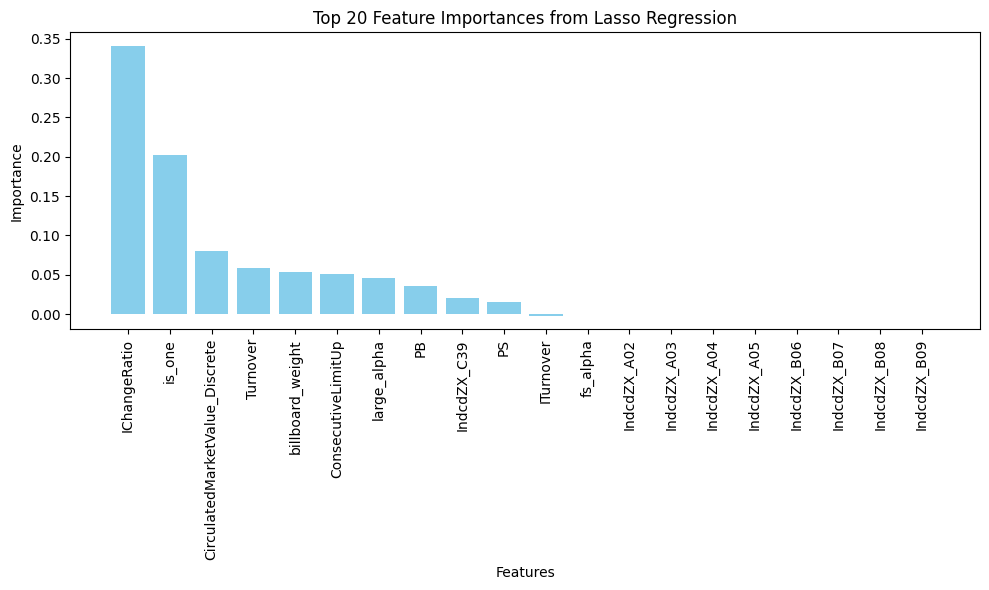

In [16]:

# 假设 df 是你的数据框
X = df.drop('discrete', axis=1)
y = df['discrete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 继续构建 Lasso 模型
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

print("Optimal alpha:", lasso_cv.alpha_)
optimal_alpha = lasso_cv.alpha_
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(X_train, y_train)

coefficients = lasso_model.coef_
feature_importances = dict(zip(X.columns, lasso_model.coef_))

# 根据绝对值排序特征重要性，并取前20个
sorted_features = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)[:20]

plt.figure(figsize=(10, 6))
plt.bar([label for label, importance in sorted_features], [importance for label, importance in sorted_features], color='skyblue')
plt.title('Top 20 Feature Importances from Lasso Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


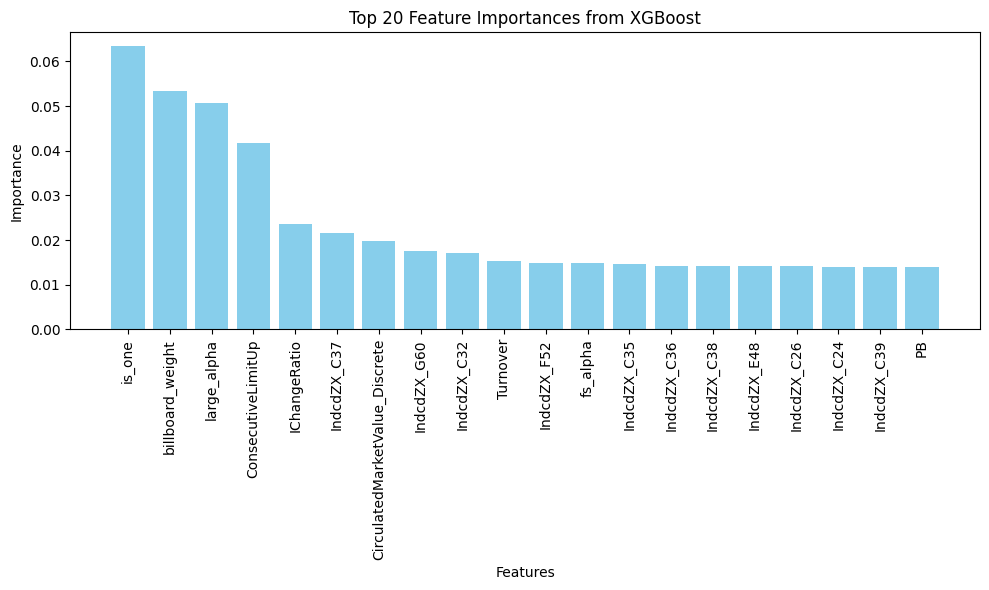

In [17]:

# 假设 df 是你的数据框
X = df.drop('discrete', axis=1)
y = df['discrete']
y = y+2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 XGBoost 进行特征筛选
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# 获取特征重要性
feature_importances = xgb_model.feature_importances_

# 将特征与其重要性结合到一起
importance_dict = dict(zip(X.columns, feature_importances))

# 根据绝对值排序特征重要性，并取前20个
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.bar([label for label, importance in sorted_features], 
        [importance for label, importance in sorted_features], 
        color='skyblue')
plt.title('Top 20 Feature Importances from XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [18]:
X_train

,ConsecutiveLimitUp,ITurnover,IChangeRatio,PB,PS,Turnover,billboard_weight,large_alpha,fs_alpha,is_one,...,IndcdZX_M75,IndcdZX_N77,IndcdZX_N78,IndcdZX_P83,IndcdZX_Q84,IndcdZX_R86,IndcdZX_R87,IndcdZX_R88,IndcdZX_R89,IndcdZX_S91
2113,3,-0.391994,-2.472793,-0.159142,-0.093776,3.166612,-0.800982,-7.76,0.000000,0,...,False,False,False,False,False,False,False,False,False,False
14323,1,0.279158,1.877576,-0.250087,-0.260648,2.204661,-1.332910,0.70,0.038824,0,...,False,False,False,False,False,False,False,False,False,False
4603,1,-0.077033,-1.019857,-0.381792,0.047689,-0.414897,0.000000,-13.46,0.006149,0,...,False,False,False,False,False,False,False,False,False,False
10157,1,-0.622470,-0.440949,-0.313374,-0.156637,-0.847377,0.000000,0.54,0.001054,0,...,False,False,False,False,False,False,False,False,False,False
451,1,-0.606925,-0.658688,-0.440990,-0.405790,-0.657550,0.000000,-4.81,0.005333,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216,1,-0.136510,-0.408367,-0.371069,-0.298711,-0.812997,0.000000,-5.62,0.001904,0,...,False,False,False,False,False,False,False,False,False,False
9252,2,2.242599,0.639133,-0.397393,-0.264897,-0.332368,0.000000,-10.35,0.012915,0,...,False,False,False,False,False,True,False,False,False,False
9602,1,-0.282501,-2.102830,4.137146,-0.178993,-0.752377,0.000000,-5.60,0.000636,0,...,False,False,False,False,False,False,False,False,False,False
1513,1,-0.369690,0.161982,-0.336781,-0.336651,0.294962,0.000000,-18.98,0.015766,0,...,False,False,False,False,False,False,False,False,False,False


In [19]:
df['discrete'], unique = pd.factorize(df['discrete'])  # 转换为离散类标签
feature = ['is_one','ConsecutiveLimitUp','IChangeRatio','billboard_weight','large_alpha','CirculatedMarketValue_Discrete','Turnover','IndcdZX_C39','IndcdZX_C37']
X = df.drop('discrete', axis=1)
X = X[feature]
y = df['discrete']

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:

X.to_csv('X_output.csv', index=False)


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# 创建决策树模型
decision_tree_model = DecisionTreeClassifier()

param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 创建网格搜索对象
grid_search_dt = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid_dt,
                               scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')

# 拟合网格搜索模型
grid_search_dt.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数:", grid_search_dt.best_params_)

# 使用最佳参数进行预测
best_decision_tree_model = grid_search_dt.best_estimator_
decision_tree_predictions = best_decision_tree_model.predict(X_test)

# 计算准确率
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)

print("最佳决策树模型准确率:", decision_tree_accuracy)
print(classification_report(y_test, decision_tree_predictions))  # 输出分类报告


最佳参数: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
最佳决策树模型准确率: 0.4997458057956279
              precision    recall  f1-score   support

           0       0.38      0.51      0.44       494
           1       0.36      0.24      0.29       353
           2       0.57      0.36      0.45       200
           3       0.38      0.42      0.40       365
           4       0.78      0.75      0.76       555

    accuracy                           0.50      1967
   macro avg       0.49      0.46      0.47      1967
weighted avg       0.51      0.50      0.50      1967



In [22]:

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 正则化参数的范围
    'max_iter': [100, 500, 1000],  # 最大迭代次数
    'solver': ['lbfgs','saga']  # 求解器类型
}

# 创建 Logistic 回归模型
logistic_model = LogisticRegression(multi_class='multinomial', random_state=42)

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')


# 拟合网格搜索模型
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 使用最佳参数进行预测
best_logistic_model = grid_search.best_estimator_
logistic_predictions = best_logistic_model.predict(X_test)

# 计算准确率
logistic_accuracy = accuracy_score(y_test, logistic_predictions)

print("最佳Logistic回归模型准确率:", logistic_accuracy)
print(classification_report(y_test, logistic_predictions))  # 输出分类报告


最佳参数: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
最佳Logistic回归模型准确率: 0.469242501270971
              precision    recall  f1-score   support

           0       0.37      0.54      0.44       494
           1       0.31      0.08      0.13       353
           2       0.72      0.41      0.52       200
           3       0.35      0.33      0.34       365
           4       0.62      0.77      0.68       555

    accuracy                           0.47      1967
   macro avg       0.47      0.42      0.42      1967
weighted avg       0.46      0.47      0.44      1967



In [23]:

# 随机森林的超参数设置
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 随机森林的网格搜索
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=rf_param_grid,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1, 
                               verbose=2)

rf_grid_search.fit(X_train, y_train)

# 获取最佳参数
best_params = rf_grid_search.best_params_
print("最佳参数:", best_params)
# 使用最佳参数训练随机森林模型
rf_model_best = RandomForestClassifier(**best_params, random_state=42)
rf_model_best.fit(X_train, y_train)

# 进行预测
rf_predictions_best = rf_model_best.predict(X_test)
rf_accuracy_best = accuracy_score(y_test, rf_predictions_best)

print("使用最佳参数的随机森林模型准确率:", rf_accuracy_best)
print(classification_report(y_test, rf_predictions_best))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
最佳参数: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
使用最佳参数的随机森林模型准确率: 0.5332994407727504
              precision    recall  f1-score   support

           0       0.42      0.58      0.49       494
           1       0.46      0.22      0.30       353
           2       0.62      0.42      0.50       200
           3       0.41      0.41      0.41       365
           4       0.74      0.81      0.77       555

    accuracy                           0.53      1967
   macro avg       0.53      0.49      0.49      1967
weighted avg       0.54      0.53      0.52      1967



In [24]:


# 定义要调节的参数
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 创建XGBoost分类器
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', n_jobs=-1, cv=3, verbose=1)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 使用最佳参数的模型进行预测
best_xgb_model = grid_search.best_estimator_
xgb_predictions = best_xgb_model.predict(X_test)

# 计算准确率
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

print("XGBoost模型准确率:", xgb_accuracy)
print(classification_report(y_test, xgb_predictions))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
最佳参数: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
XGBoost模型准确率: 0.5175394001016776
              precision    recall  f1-score   support

           0       0.39      0.57      0.46       494
           1       0.44      0.14      0.22       353
           2       0.59      0.41      0.48       200
           3       0.41      0.41      0.41       365
           4       0.73      0.82      0.77       555

    accuracy                           0.52      1967
   macro avg       0.51      0.47      0.47      1967
weighted avg       0.52      0.52      0.50      1967



In [25]:

# 定义要调节的参数
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'bootstrap_type': ['Bernoulli']  # 设置引导类型为Bernoulli
}

# 创建CatBoost分类器
catboost_model = CatBoostClassifier(silent=True, random_state=42)

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid,
                           scoring='accuracy', n_jobs=-1, cv=3, verbose=1)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 使用最佳参数的模型进行预测
best_catboost_model = grid_search.best_estimator_
catboost_predictions = best_catboost_model.predict(X_test)

# 计算准确率
catboost_accuracy = accuracy_score(y_test, catboost_predictions)

print("CatBoost模型准确率:", catboost_accuracy)
print(classification_report(y_test, catboost_predictions))



Fitting 3 folds for each of 18 candidates, totalling 54 fits
最佳参数: {'bootstrap_type': 'Bernoulli', 'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
CatBoost模型准确率: 0.5256736146415861
              precision    recall  f1-score   support

           0       0.40      0.52      0.45       494
           1       0.41      0.29      0.34       353
           2       0.64      0.46      0.53       200
           3       0.40      0.38      0.39       365
           4       0.76      0.81      0.78       555

    accuracy                           0.53      1967
   macro avg       0.52      0.49      0.50      1967
weighted avg       0.53      0.53      0.52      1967



In [26]:

class_names = [0, 1, 2, 3, 4, 5]



def plot_confusion_matrix(model, X_test, y_test,  figsize=(10, 7)):
    # 预测测试集
    y_pred = model.predict(X_test)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'{model.__class__.__name__} confusion matrix')
    plt.xlabel('prediction label')
    plt.ylabel('true label')
    plt.show()

    

def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', labels=class_names)
    recall = recall_score(y_test, y_pred, average='macro', labels=class_names)
    f1 = f1_score(y_test, y_pred, average='macro', labels=class_names)
    
    return accuracy, precision, recall, f1

def plot_bar_chart(metric_name, values, color='#00BFFF'):
    plt.figure(figsize=(14, 8))
    bars = plt.bar(results.keys(), values, color=color)
    plt.title(metric_name)
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # 在每个柱上添加文本
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()





Model type: <class 'catboost.core.CatBoostClassifier'>
Model type: <class 'xgboost.sklearn.XGBClassifier'>
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Model type: <class 'sklearn.tree._classes.DecisionTreeClassifier'>


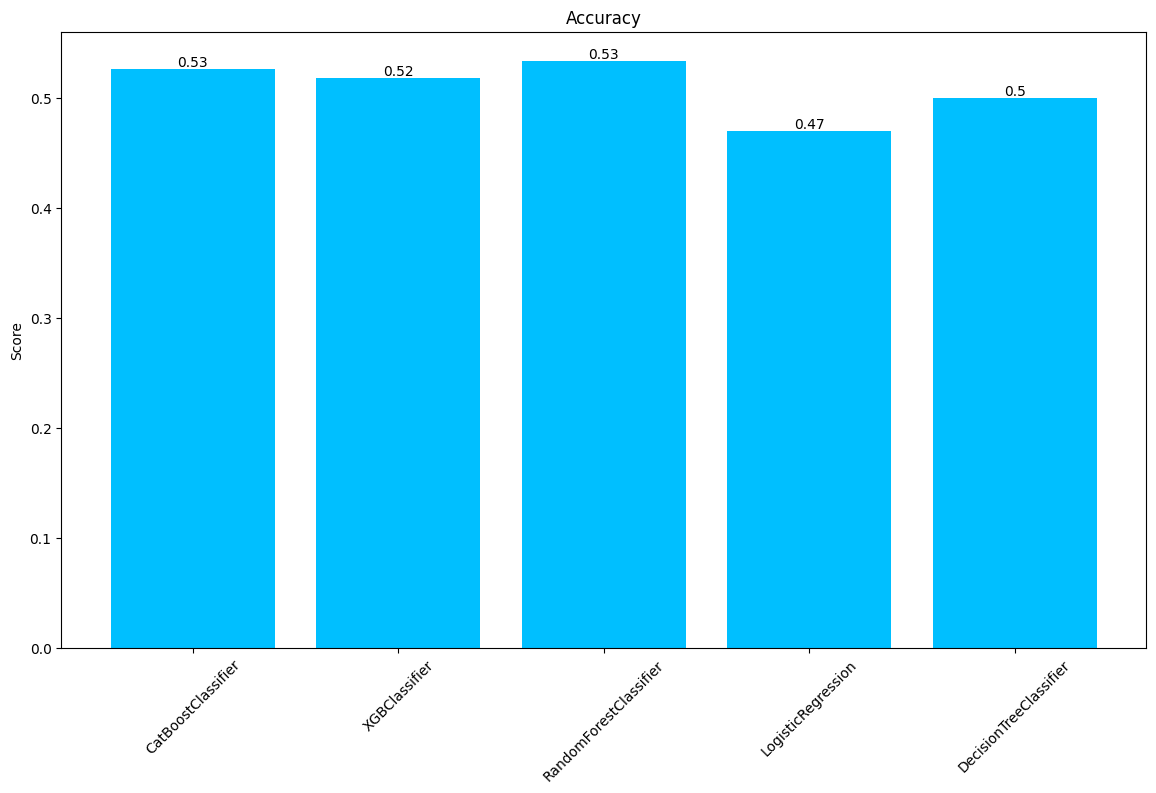

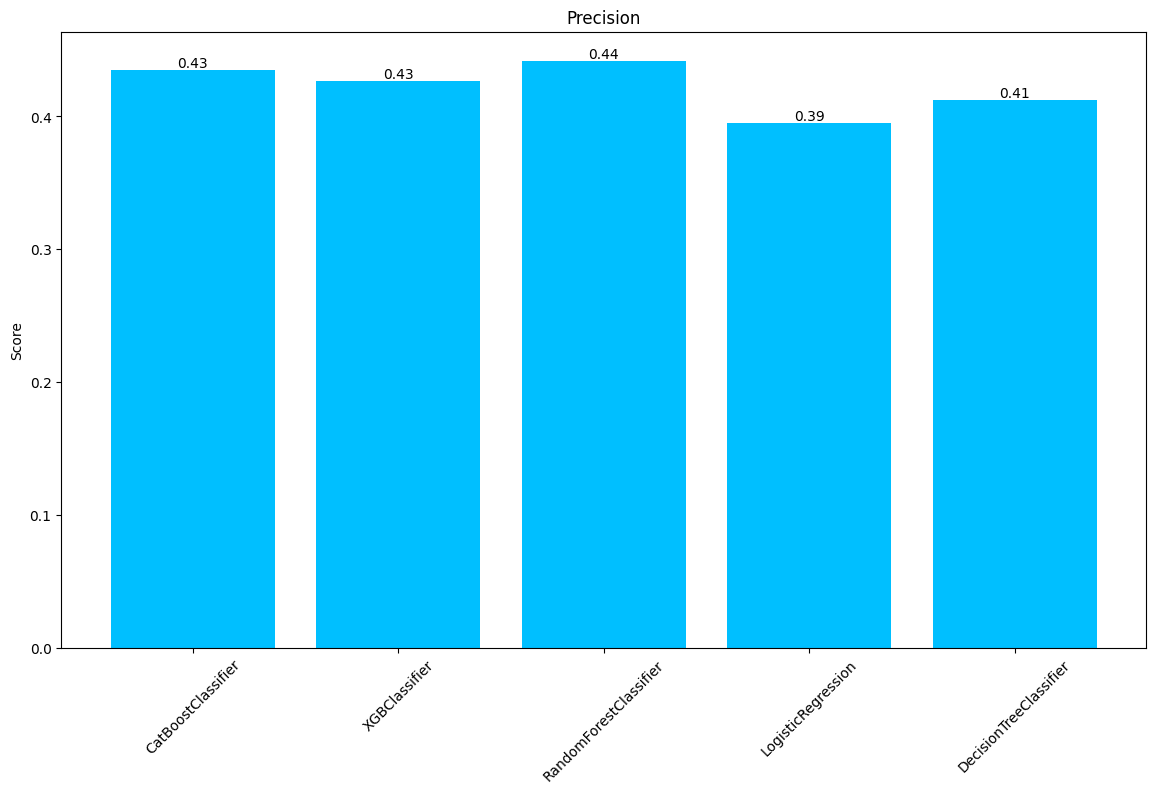

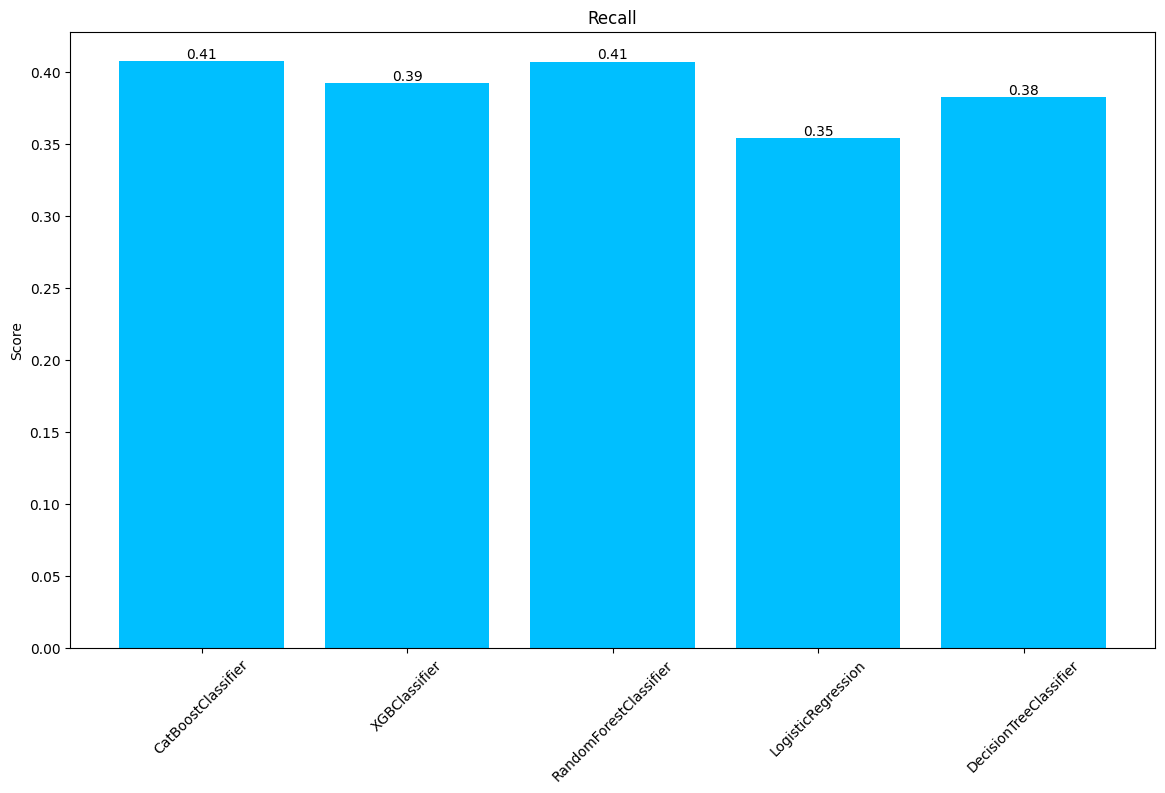

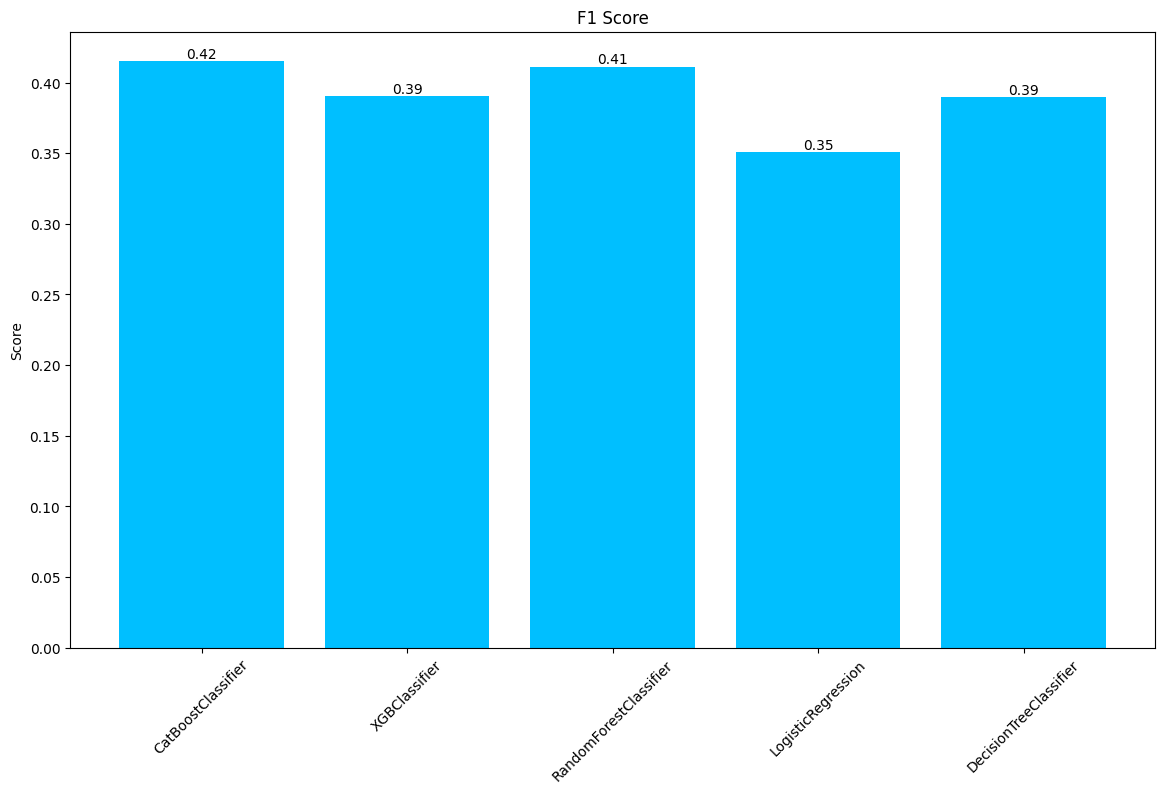

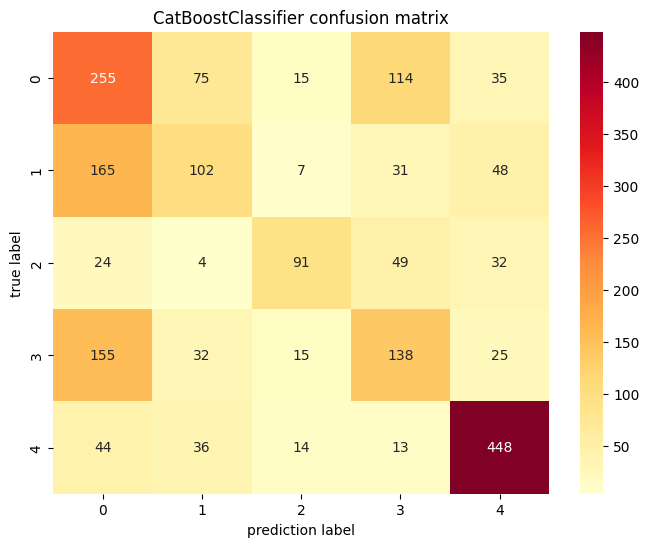

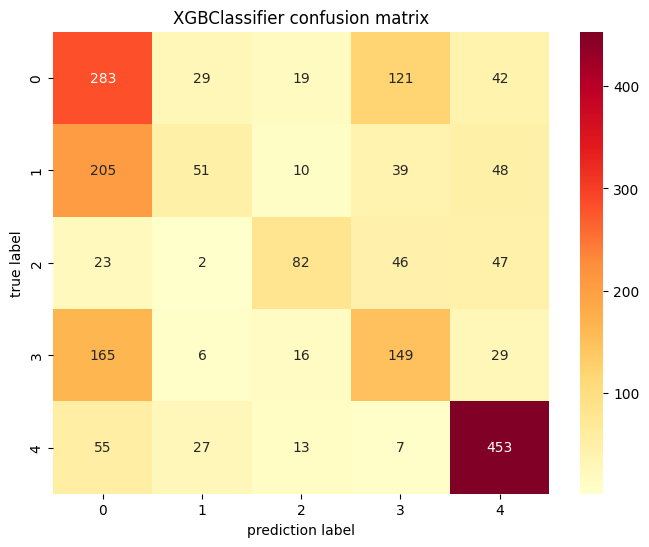

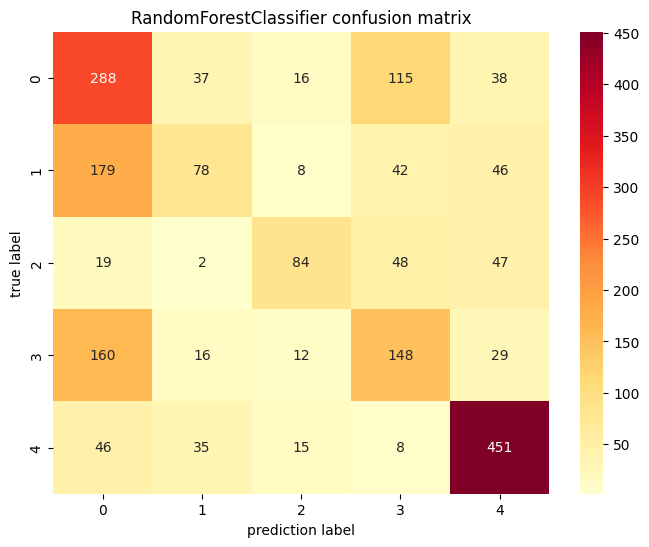

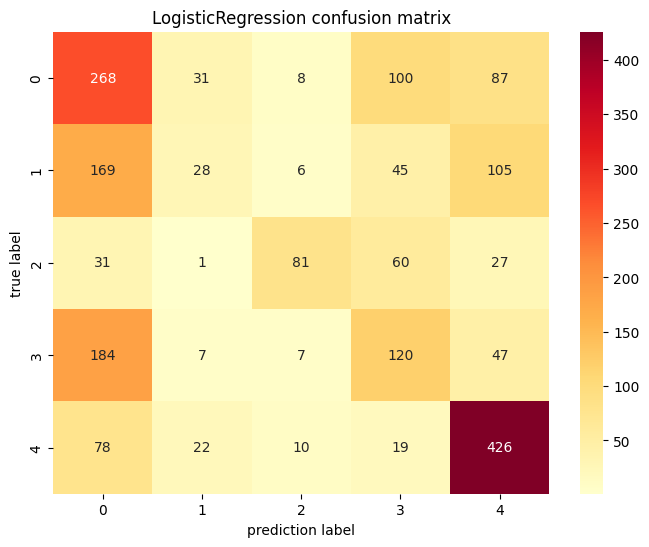

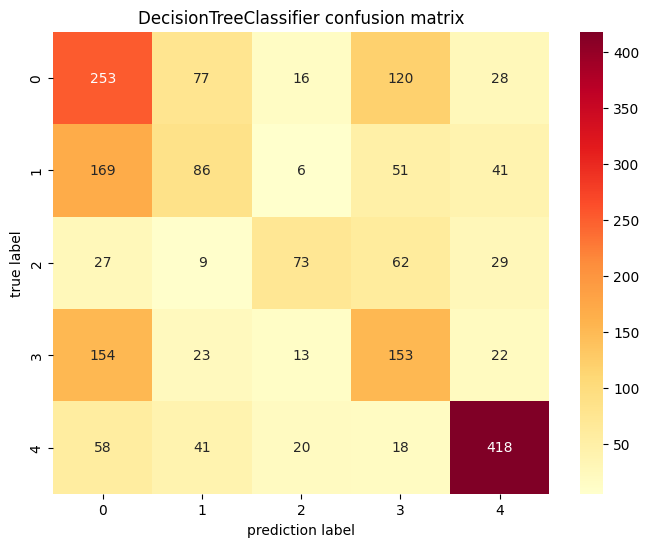

In [27]:
# 存储所有模型的评估结果
results = {}
models = [best_catboost_model, best_xgb_model, rf_model_best, best_logistic_model, best_decision_tree_model]  # 假设这是你的模型列表


for model in models:
    print(f'Model type: {type(model)}')  # 检查模型的类型
    model_name = model.__class__.__name__
    results[model_name] = evaluate_model(model, X_test, y_test, class_names)

# 定义指标名称和对应的值
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [
    [result[0] for result in results.values()],
    [result[1] for result in results.values()],
    [result[2] for result in results.values()],
    [result[3] for result in results.values()]
]

# 使用循环调用绘图函数
for metric_name, value in zip(metrics, values):
    plot_bar_chart(metric_name, value)
    
for model in models:
    plot_confusion_matrix(model, X_test, y_test)

Model type: <class 'catboost.core.CatBoostClassifier'>
Model type: <class 'xgboost.sklearn.XGBClassifier'>
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Model type: <class 'sklearn.tree._classes.DecisionTreeClassifier'>


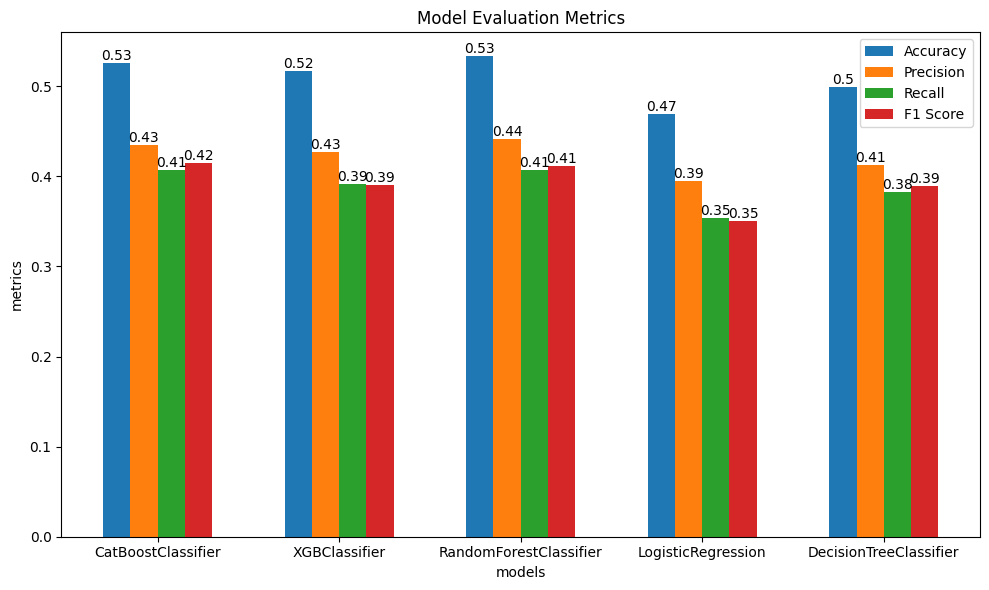

In [28]:


# 假设你的模型评估结果已经存储在results字典中
results = {}
models = [best_catboost_model, best_xgb_model, rf_model_best, best_logistic_model, best_decision_tree_model]  # 模型列表

# 评估模型并存储结果
for model in models:
    print(f'Model type: {type(model)}')  # 检查模型的类型
    model_name = model.__class__.__name__
    results[model_name] = evaluate_model(model, X_test, y_test, class_names)

# 定义指标名称和对应的值
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = list(results.keys())

# 准备每个指标的数据
values = np.array([
    [result[i] for result in results.values()] for i in range(4)
])

# 设置柱状图的参数
bar_width = 0.15  # 每个柱子的宽度
x = np.arange(len(model_names))  # 模型的索引

# 创建柱状图
plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    bars = plt.bar(x + i * bar_width, values[i], width=bar_width, label=metric)

    # 在每个柱上显示数字
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# 添加标签和标题
plt.xlabel('models')
plt.ylabel('metrics')
plt.title('Model Evaluation Metrics')
plt.xticks(x + bar_width * 1.5, model_names)  # 设置x轴的刻度
plt.legend()

# 调整布局并显示图形
plt.tight_layout()
plt.show()


In [29]:


# 假设你有一个训练数据集 X_train
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_train)


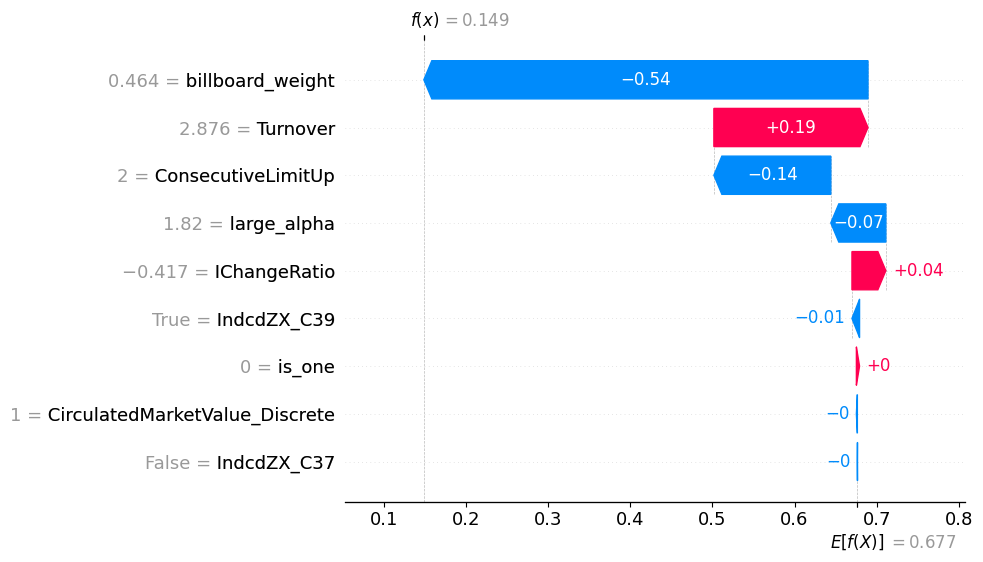

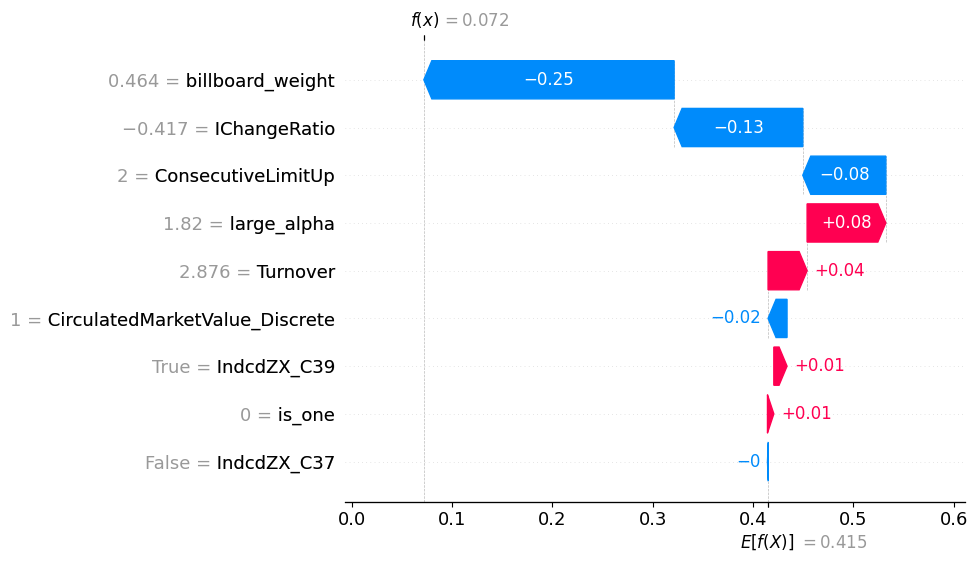

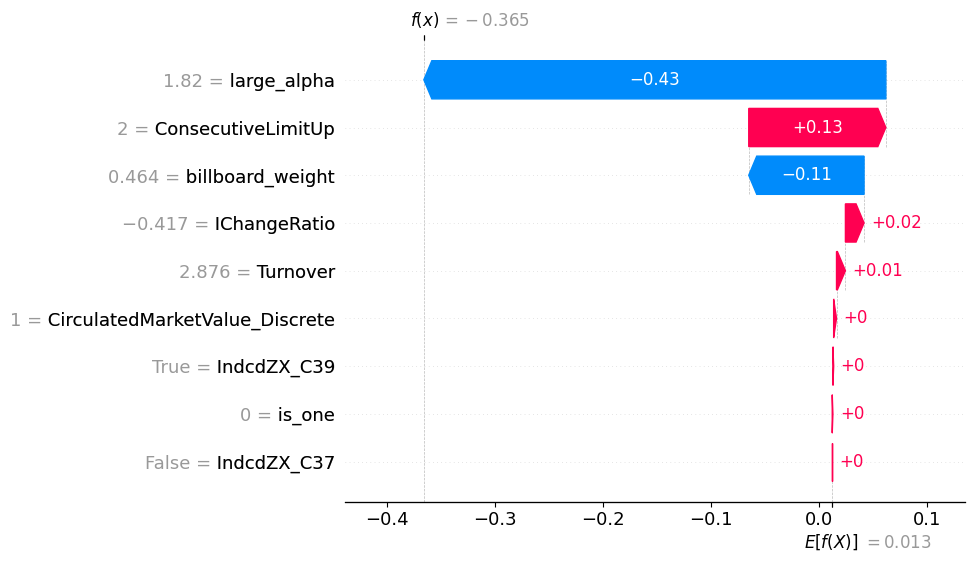

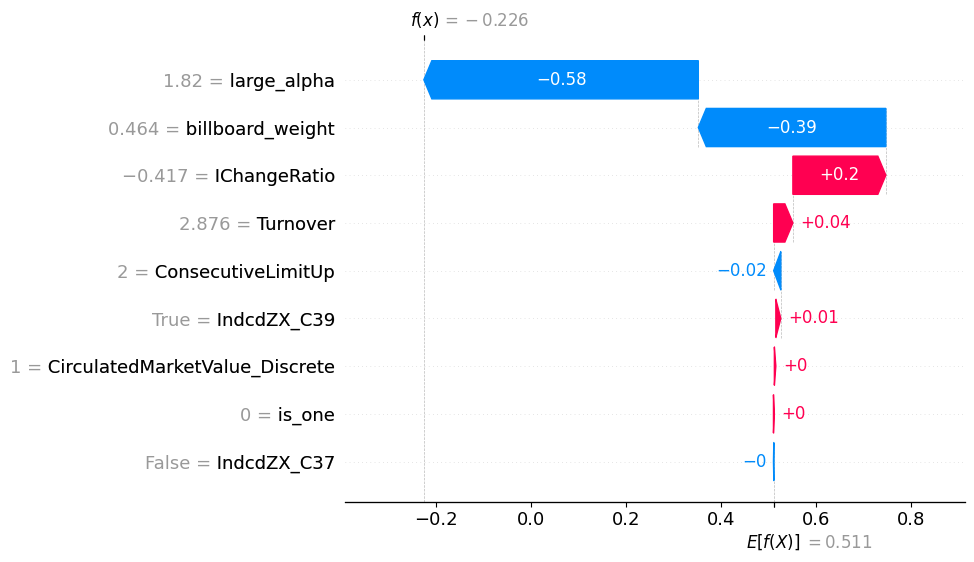

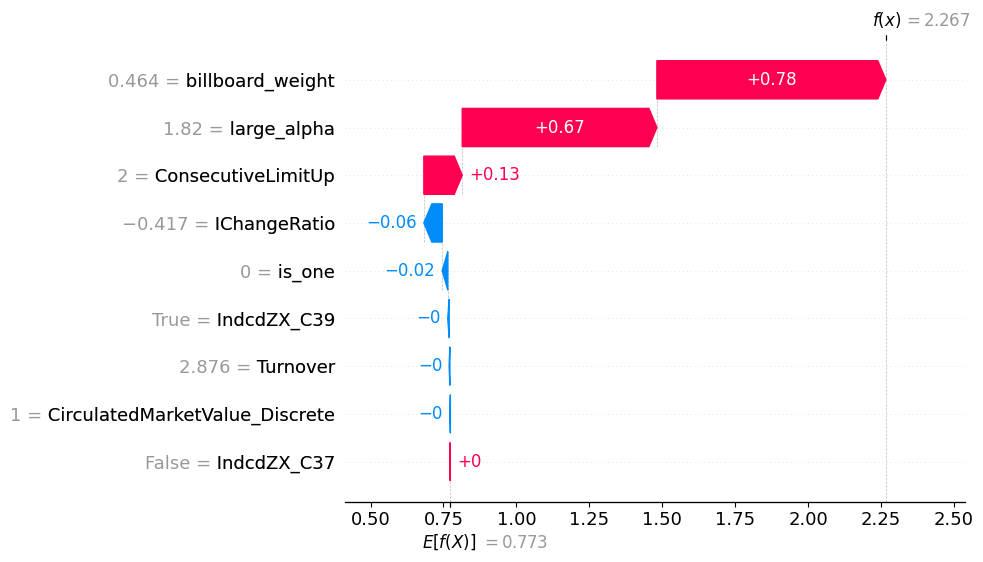

In [30]:
shap_values = explainer(X_test)
for i in range(5):
    shap.plots.waterfall(shap_values[0,:,i])

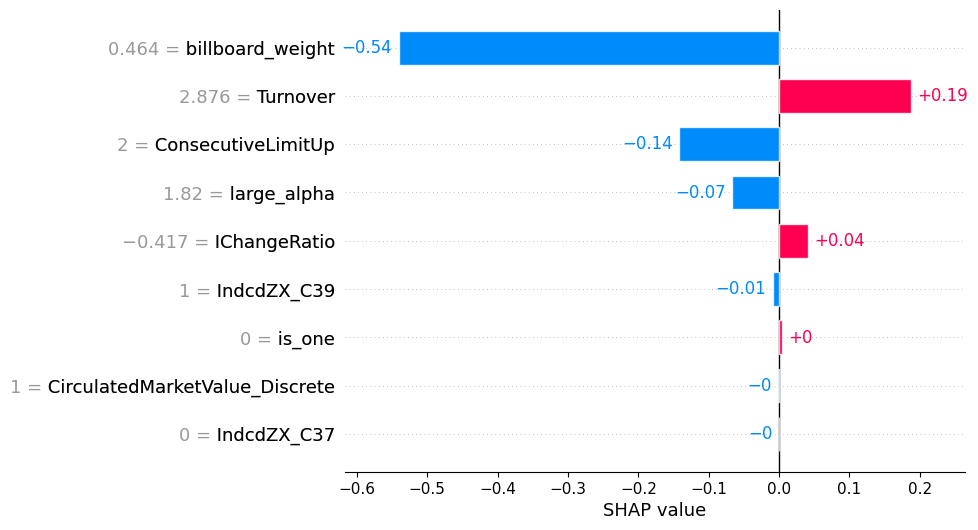

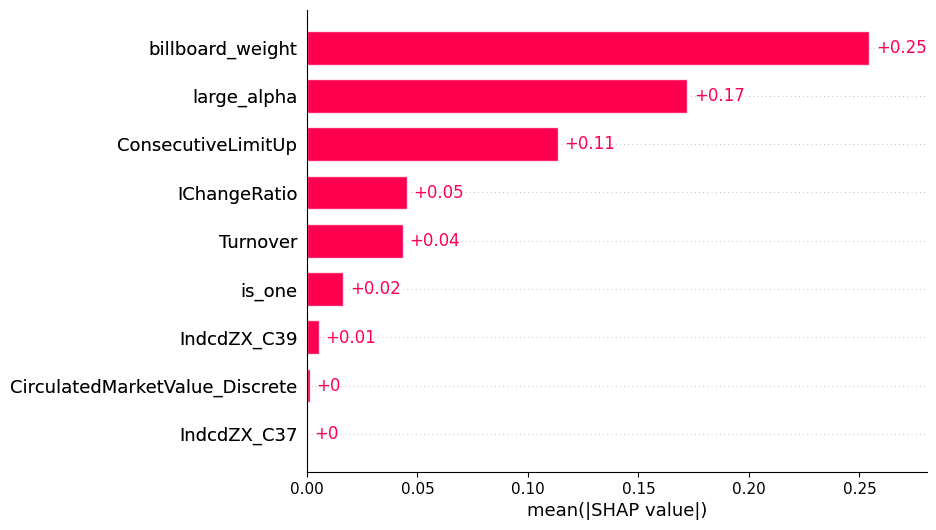

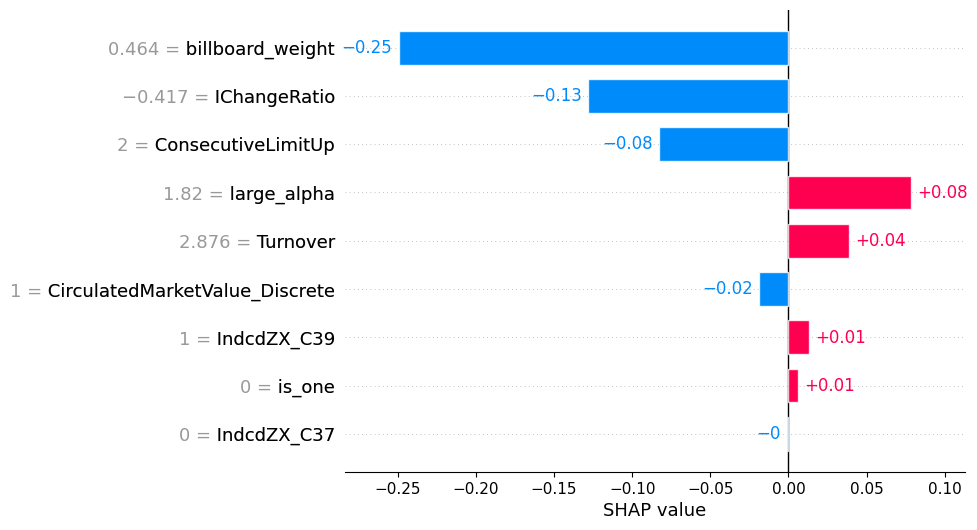

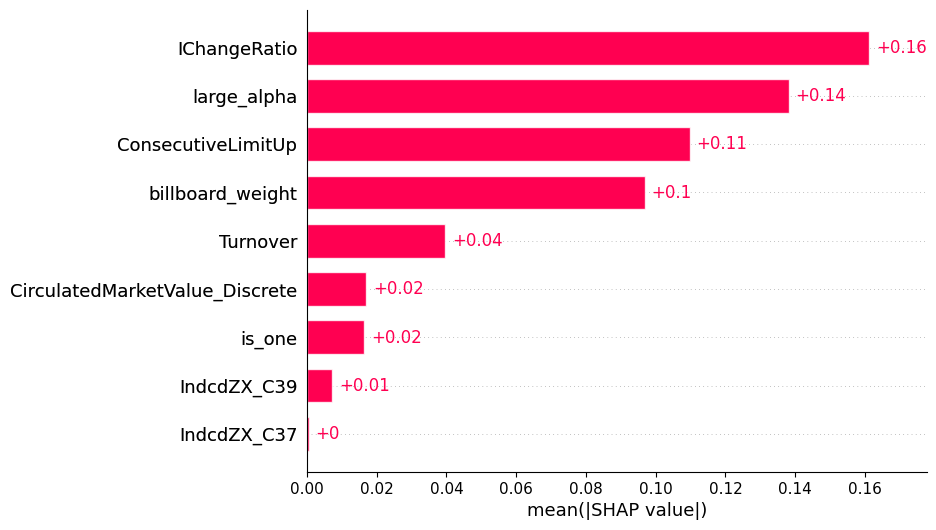

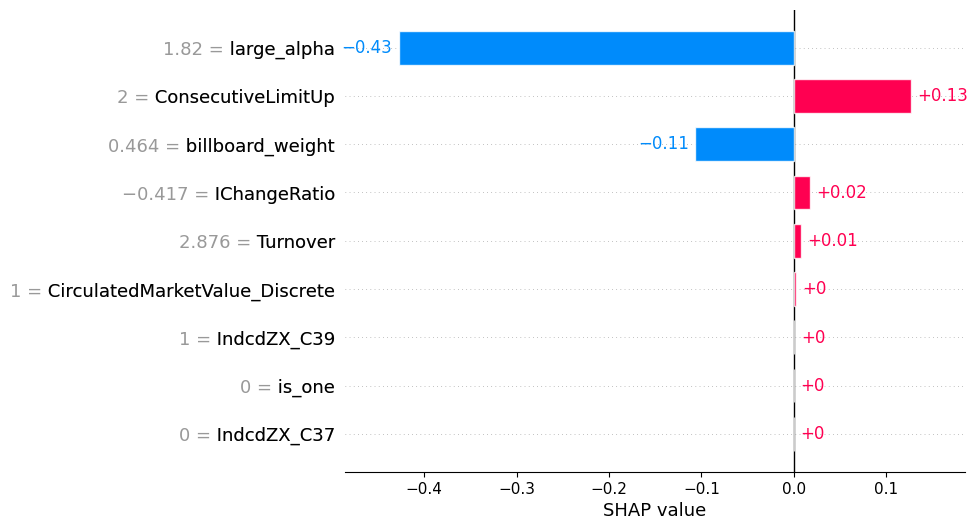

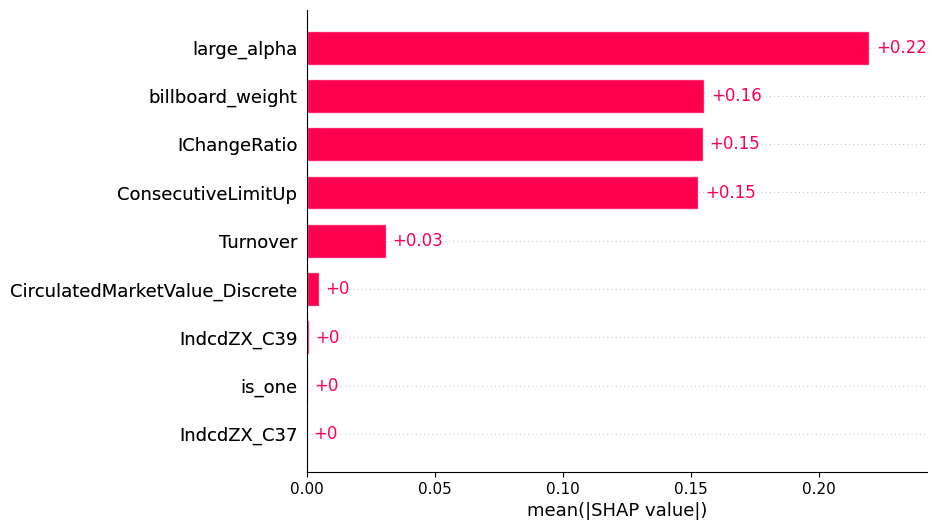

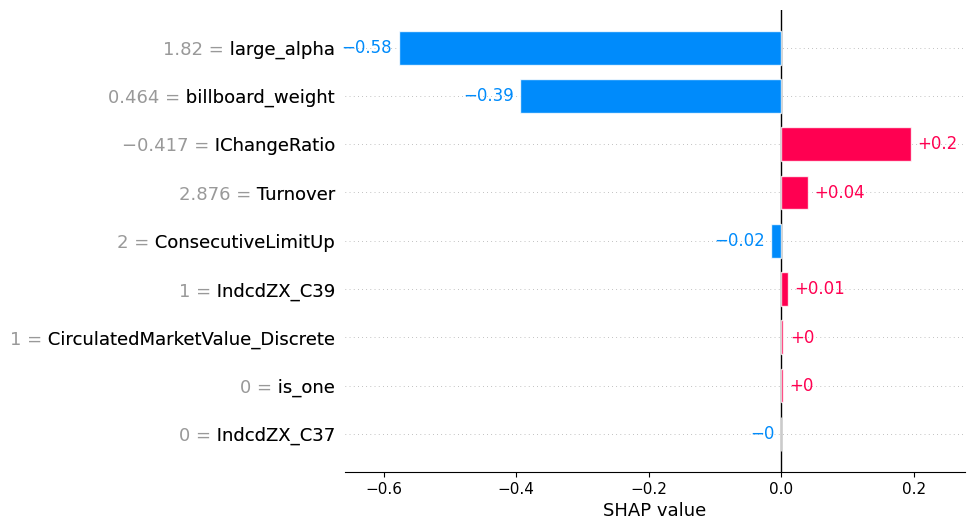

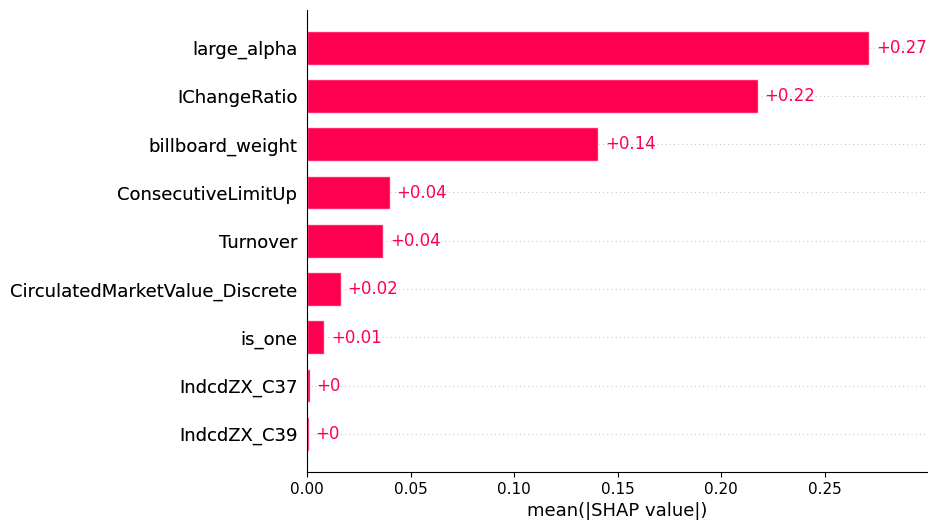

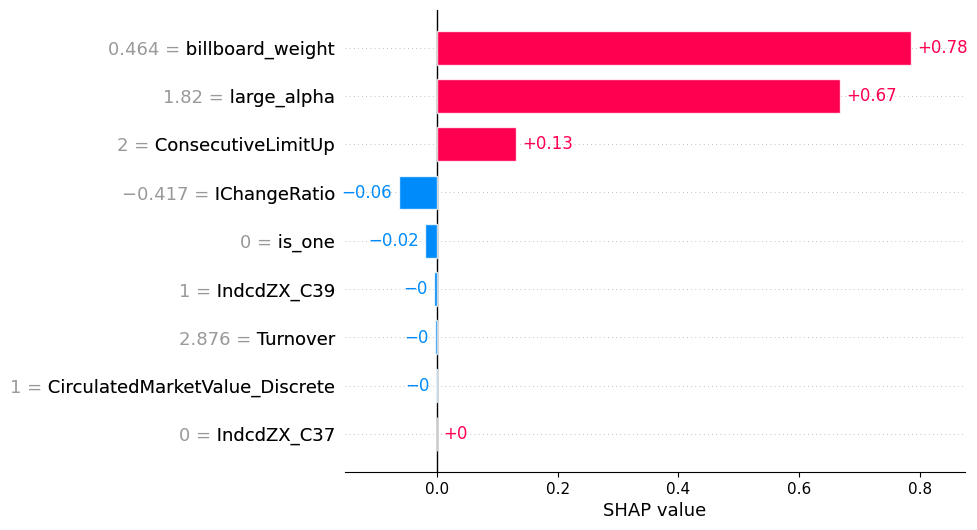

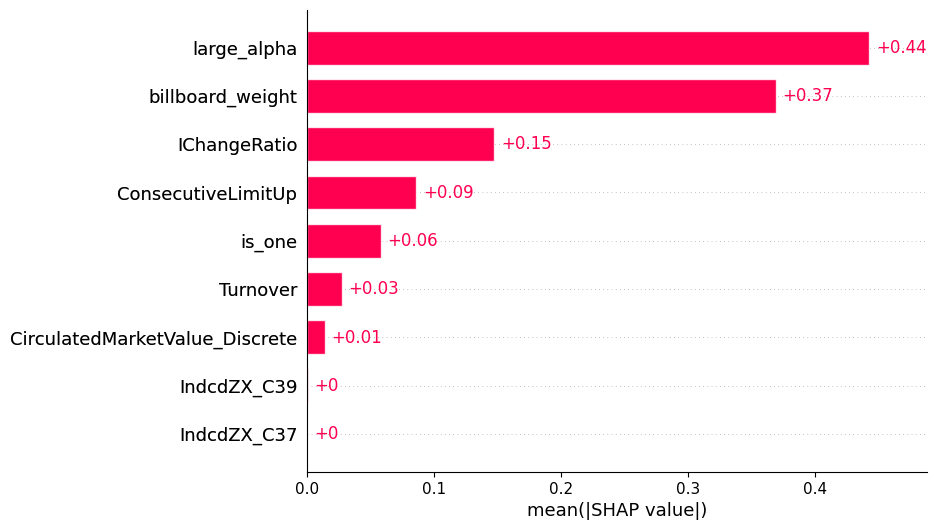

In [31]:
for i in range(5):
    shap.plots.bar(shap_values[0,:,i])
    shap.plots.bar(shap_values[:,:,i])

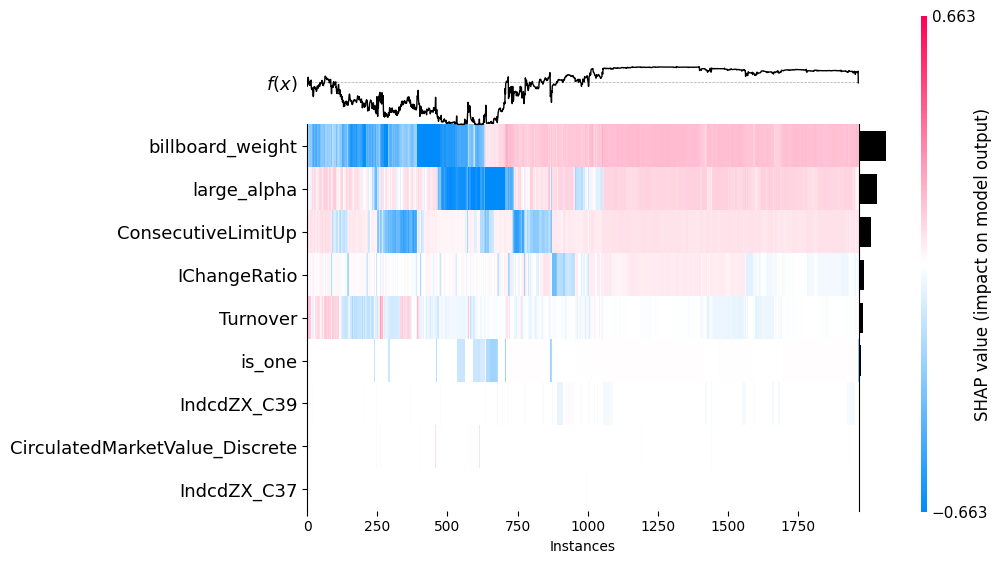

In [32]:
shap.plots.heatmap(shap_values[:,:,0])
plt.show()

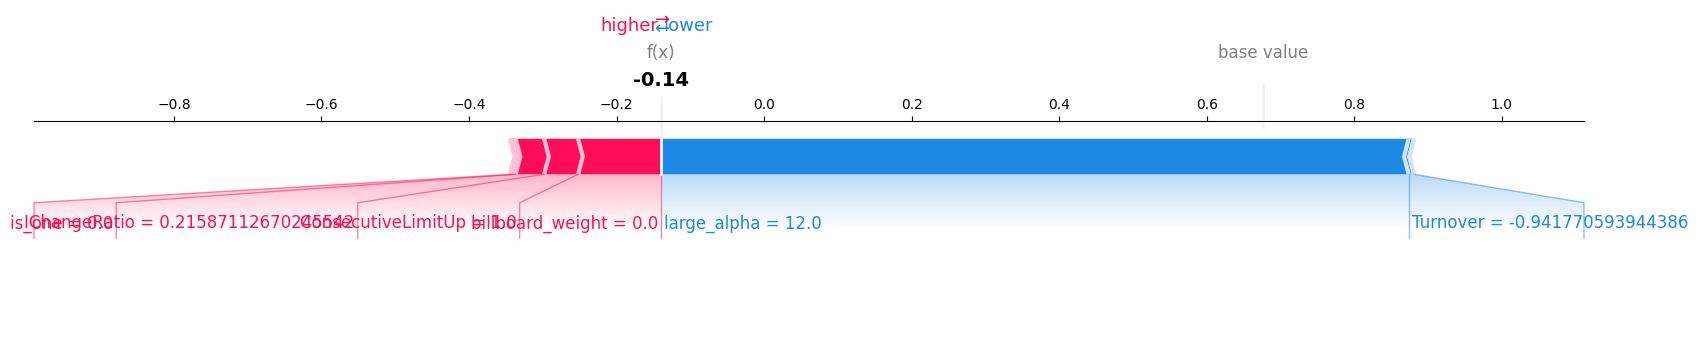

<Figure size 640x480 with 0 Axes>

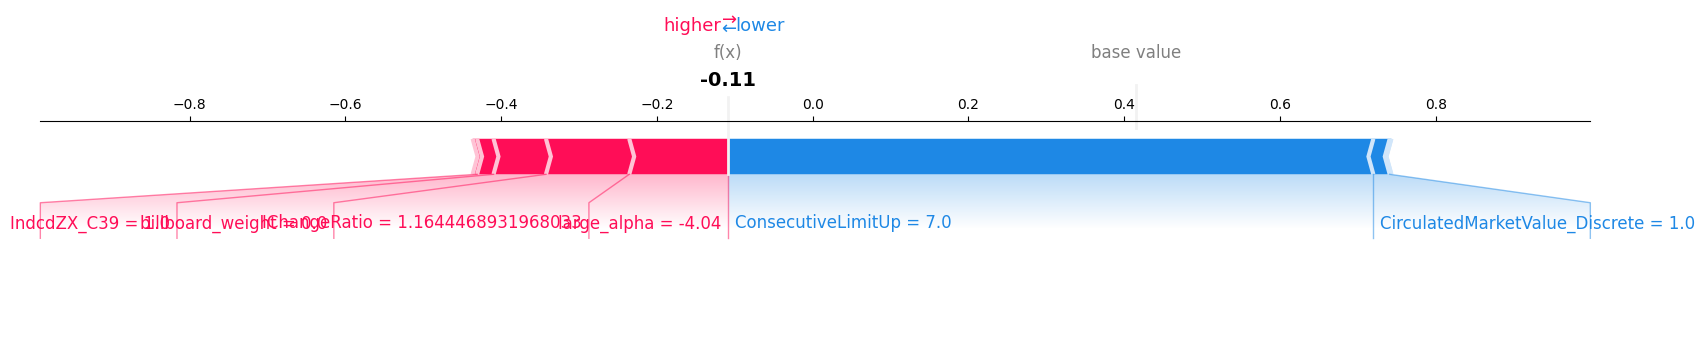

<Figure size 640x480 with 0 Axes>

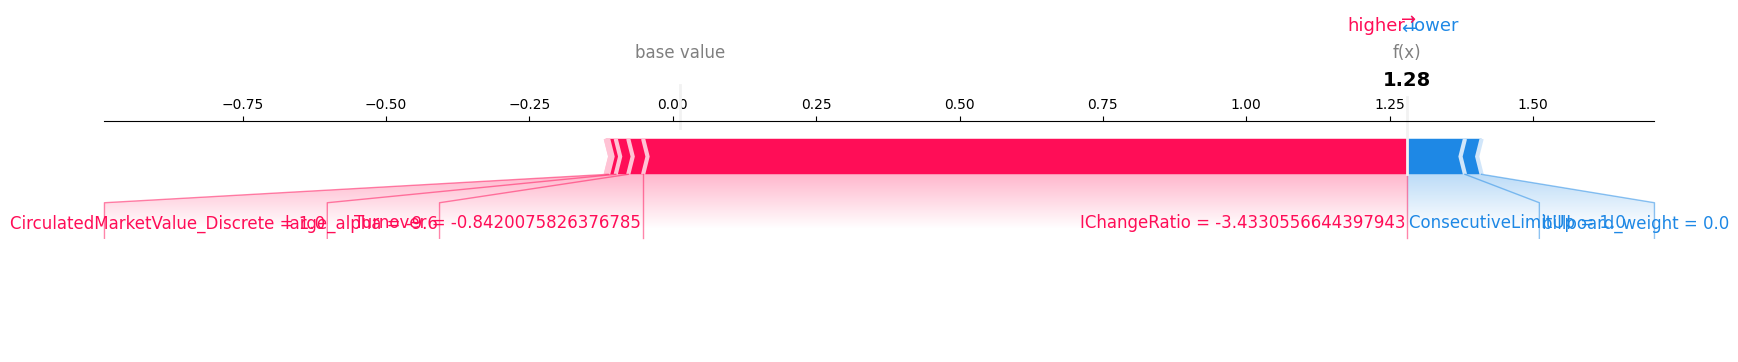

<Figure size 640x480 with 0 Axes>

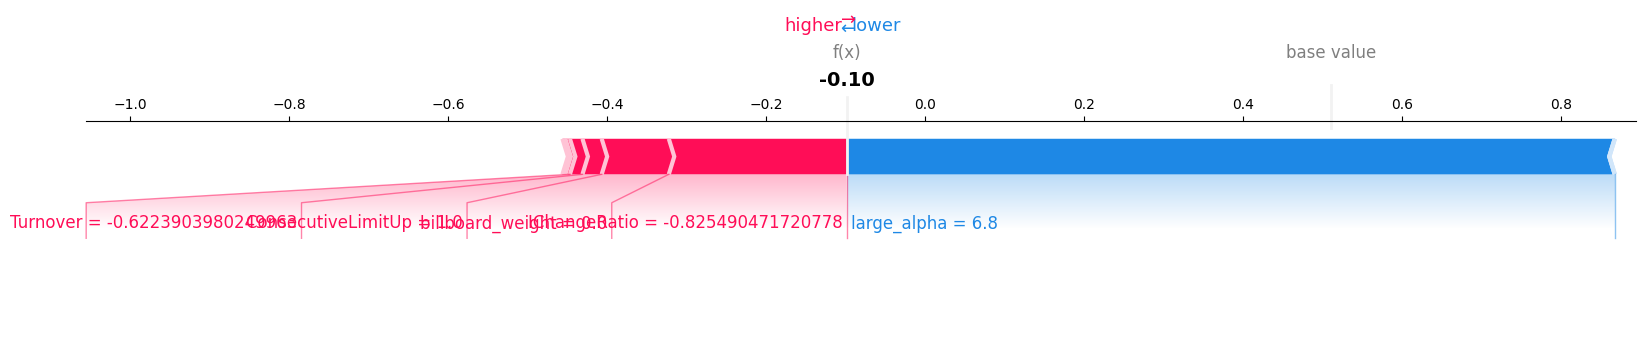

<Figure size 640x480 with 0 Axes>

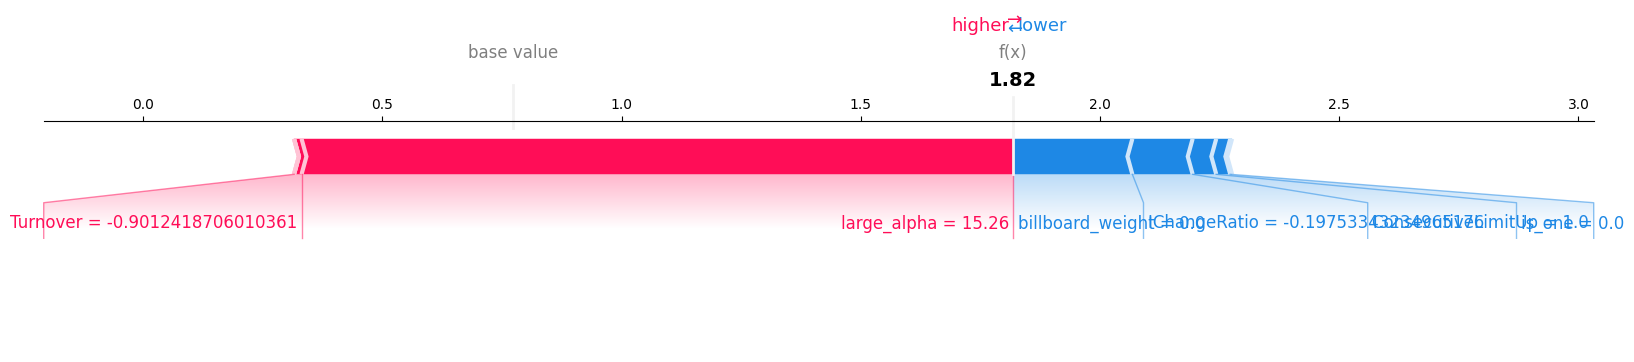

<Figure size 640x480 with 0 Axes>

In [33]:

shap_values = explainer.shap_values(X_train)
# 选择每个类别中 SHAP 值绝对值最大的样本
sample_indices = [np.unravel_index(np.argmax(np.abs(shap_values[:, :, i])), shap_values.shape[:2]) for i in range(5)]

# 绘制每个类别的 force plot
for i in range(5):  # 遍历每个类别
    idx = sample_indices[i][0]  # 选择代表性样本的索引
    features_sample = X_train.iloc[idx]  # 第 i 个类别代表性样本的特征数据
    shap_values_sample = shap_values[idx, :, i]  # 第 i 个类别代表性样本的 SHAP 值

    # 创建 SHAP Explanation 对象
    shap_exp = shap.Explanation(
        values=shap_values_sample,
        base_values=explainer.expected_value[i],
        data=features_sample,
        feature_names=X.columns.tolist()
    )
    
    # 绘制 force plot
    shap.force_plot(shap_exp, matplotlib=True)
    plt.suptitle(f"Force Plot for Class {i}",fontsize=20,
             y=1.3)
    plt.show()  # 显示图形

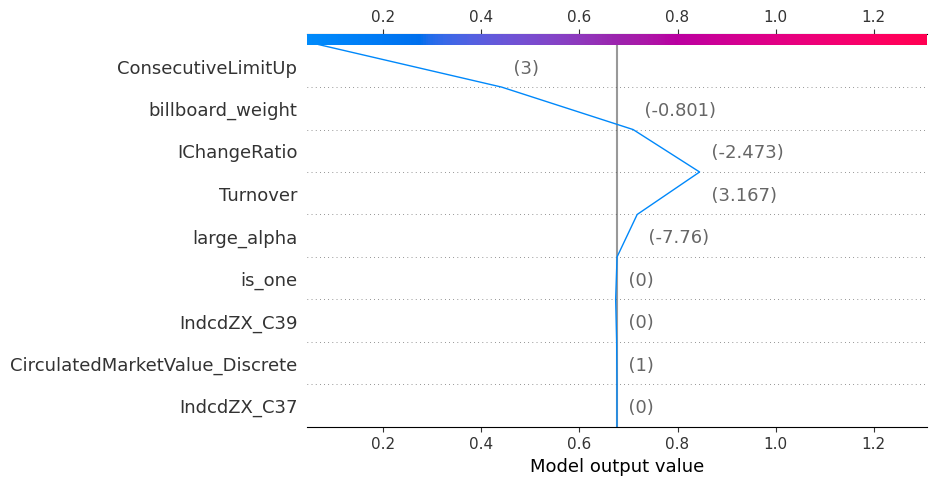

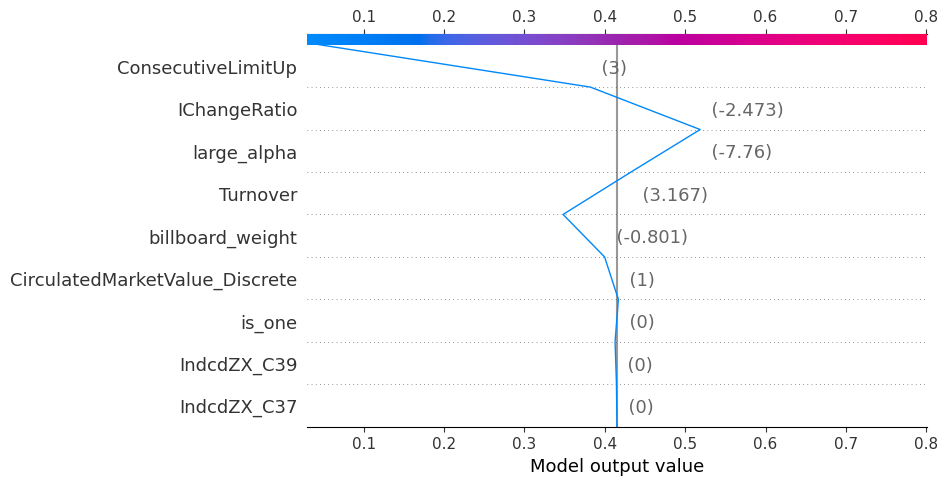

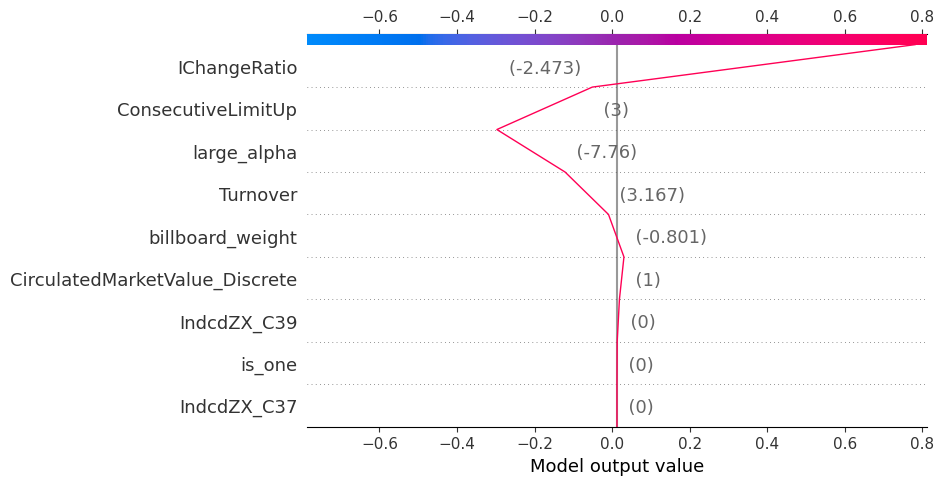

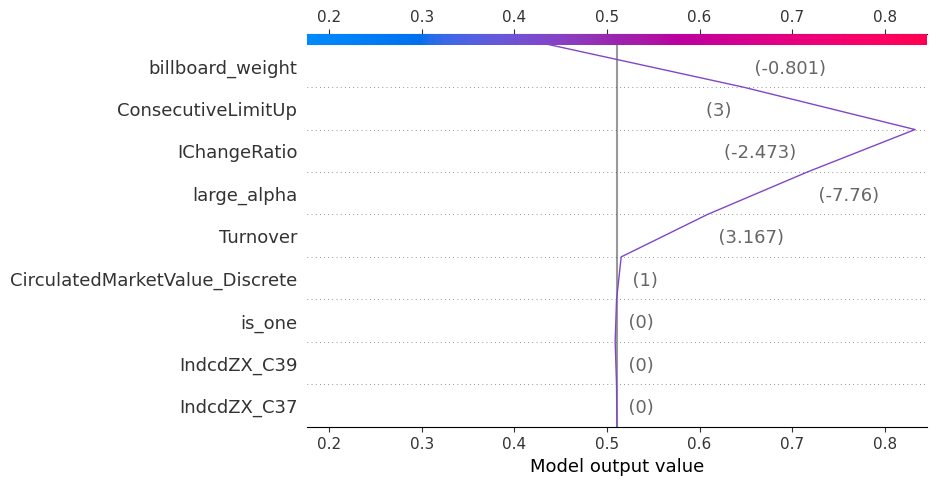

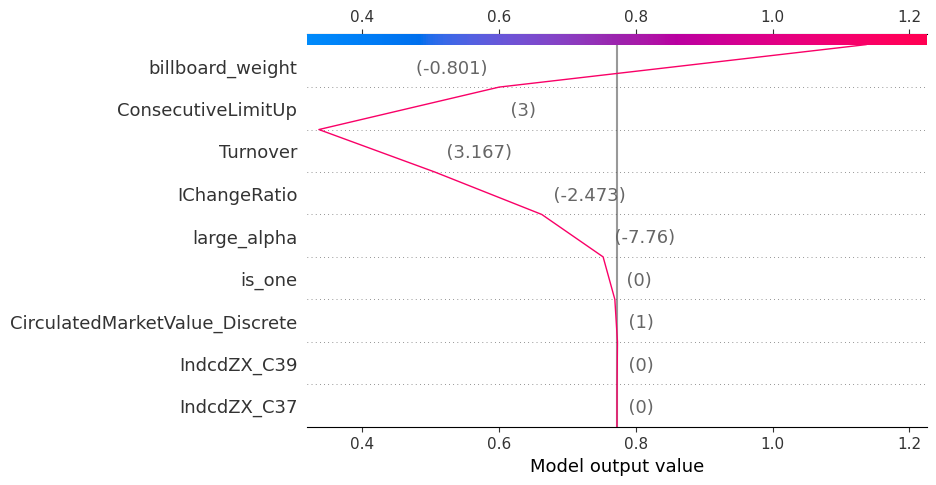

In [34]:
row_index = 0
sample_features = X_train.iloc[row_index].values.reshape(1, -1)


n_classes = 5
for class_index in range(n_classes):#假设想查看第0个类别
    shap_value =shap_values[row_index,:,class_index]#得到形状为(n_features,)的数组
    base_value =explainer.expected_value[class_index]
    # 选择该样本的特征数据
    sample_features = X_train.iloc[row_index]

    # 确保 feature_names 与 shap_values 的特征一致
    feature_names = X_train.columns.tolist()

    # 绘制决策图
    shap.decision_plot(
        base_value,  # 基准值
        shap_value,  # 选定样本的 SHAP 值
        sample_features,  # 选定样本的特征数据
        feature_names=feature_names,
    )


In [ ]:
import pickle
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(best_catboost_model, file)
